In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Conv1D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]
from joblib import Parallel, delayed

## Reading and preparing data

In [2]:
df = pd.read_csv("../data/processed/train.csv") 
df.head(n=5)  # visualize the data.

,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0,1.0,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,...,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,1,0,1.0,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,...,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,2,0,1.0,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,...,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,3,0,1.0,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,...,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,4,0,1.0,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,...,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681


In [3]:
# Remove simulation columns
df = df.drop(['simulationRun', 'sample', 'Unnamed: 0'], axis=1)
#ignore the hard to detect faults
df = df.drop(df[(df.faultNumber == 3) | (df.faultNumber == 9) | (df.faultNumber == 15)].index).reset_index()
#make label binary
df.loc[df['faultNumber'] > 0, 'faultNumber'] = 1


In [4]:
#balance classes
df = df[df['faultNumber']!=0].sample(n=len(df[df['faultNumber']==0])).append(df[df['faultNumber']==0])
df

,index,faultNumber,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
1775941,2004421,1,0.67782,3598.3,4433.6,8.4818,27.025,41.472,2703.4,76.963,...,52.862,66.524,55.708,18.901,23.442,43.325,47.673,34.174,39.221,20.641
5483361,6366561,1,0.28924,3657.7,4361.6,9.8264,27.128,42.575,2675.8,71.933,...,52.338,28.952,65.931,21.808,40.045,42.415,48.800,30.116,39.409,15.966
6594337,7673377,1,0.28443,3614.5,4526.2,9.2829,26.934,42.143,2700.5,74.604,...,54.184,27.936,60.924,21.409,39.476,38.000,46.045,45.477,41.313,18.931
4578773,5302613,1,0.23573,3627.2,4479.8,9.3398,26.952,42.309,2704.5,75.166,...,53.781,23.806,61.833,22.301,38.591,40.994,47.316,50.161,44.732,18.260
2866242,3287682,1,0.25882,3675.1,4501.0,9.3489,26.960,42.499,2701.8,74.750,...,53.800,25.777,61.220,22.149,41.274,37.047,48.394,51.199,40.898,19.910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,479995,0,0.26428,3671.5,4510.8,9.2852,27.141,42.297,2699.9,74.296,...,53.942,26.022,61.709,22.417,40.510,36.731,50.115,52.721,40.927,18.854
479996,479996,0,0.25132,3573.4,4483.9,9.2872,26.604,42.311,2698.1,74.629,...,53.760,24.585,61.267,21.928,39.893,34.136,47.714,52.908,41.412,18.847
479997,479997,0,0.25105,3622.6,4433.3,9.3998,26.707,41.936,2699.5,75.484,...,54.366,24.613,61.745,22.212,40.098,35.585,48.241,53.099,40.150,16.791
479998,479998,0,0.24521,3660.5,4485.2,9.3885,26.936,42.639,2700.5,74.614,...,53.289,24.371,62.811,22.249,39.536,35.609,46.495,53.157,41.065,17.097


# Prepare data for CNN models

In [5]:
X = df.loc[:, df.columns != 'faultNumber'].values  # converts the df to a numpy array
y = df['faultNumber'].values

n_features = X.shape[1]  # number of features

print(n_features)


53


### Divide the data into train, valid, and test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_test, y_test, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [7]:
X_train.shape

(153600, 53)

In [8]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train!=0] #any fault

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid!=0] #any fault

In [9]:
print(X_valid_y0.shape)
print(X_valid_y1.shape)

(19216, 53)
(19184, 53)


In [10]:
X_train = X_train.reshape(-1,1, n_features)
X_train_y0 = X_train_y0.reshape(-1,1, n_features)
X_train_y1 = X_train_y1.reshape(-1,1, n_features)

X_test = X_test.reshape(-1,1, n_features)

X_valid = X_valid.reshape(-1, 1, n_features)
X_valid_y0 = X_valid_y0.reshape(-1, 1, n_features)
X_valid_y1 = X_valid_y1.reshape(-1, 1, n_features)

In [11]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [12]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## CNN ATTENTION Autoencoder training

Initialize v1 of the autoencoder architecture. More experimentation possible

In [13]:
n_features =  X_train_y0.shape[2] # 52
timesteps=5
epochs = 10
batch = 512
lr = 0.001
num_inducing_points = n_features

In [14]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(Attention, self).build(input_shape)

    def call(self,x):
        et=tf.squeeze(tf.math.tanh(tf.keras.backend.dot(x,self.W)+self.b),axis=-1)
        at=tf.nn.softmax(et)
        at=tf.expand_dims(at,axis=-1)
        output=x*at
        return tf.math.reduce_sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(Attention,self).get_config()

Define the trainable prior and posterior distributions to estimate uncertainties

In [15]:
input_shape=(timesteps, n_features)
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(timesteps), scale=1),
                        reinterpreted_batch_ndims=1)
inputs=Input((1,n_features))
Layer_1=Conv1D(128,kernel_size=1, activation=LeakyReLU(alpha=0.05))(inputs)
Dropout_1 = Dropout(0.1)(Layer_1)
Layer_2=Conv1D(64,kernel_size=1, activation=LeakyReLU(alpha=0.05))(Dropout_1)
Dropout_2 = Dropout(0.1)(Layer_2)
att_in=Conv1D(32,kernel_size=1, activation=LeakyReLU(alpha=0.05))(Dropout_2)
att_out=Attention()(att_in)
Layer_3 = Dense(tfpl.MultivariateNormalTriL.params_size(timesteps),
                       activation=None)(att_out)
Layer_4 = tfpl.MultivariateNormalTriL(
                        timesteps,
                        activity_regularizer=tfpl.KLDivergenceRegularizer(prior))(Layer_3)
Layer_5 = RepeatVector(timesteps)(Layer_4)
Layer_6=Conv1D(32,kernel_size=1, activation=LeakyReLU(alpha=0.05))(Layer_5)
Dropout_3 = Dropout(0.1)(Layer_6)
Layer_7=Conv1D(64,kernel_size=1, activation=LeakyReLU(alpha=0.05))(Dropout_3)
Dropout_4 = Dropout(0.1)(Layer_7)
Layer_8=Conv1D(128,kernel_size=1, activation=LeakyReLU(alpha=0.05))(Dropout_4)
att_out_2 = Attention()(Layer_8)
Layer_9=Dense(tfpl.IndependentNormal.params_size(n_features),
                       activation=None)(att_out_2)
outputs=tfpl.IndependentNormal(n_features)(Layer_9)
lstm_autoencoder=Model(inputs,outputs)
# returns n_features independent normal distributions.
# note: an Autoencoder tries to "recreate" the input
adam = optimizers.Adam(lr)

#neg loglikelihood for well defined covariance matrices
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
lstm_autoencoder.compile(loss=negative_log_likelihood, optimizer=adam)

lstm_autoencoder.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 53)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            6912      
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 32)             2080      
________________________________________

In [16]:
cp = ModelCheckpoint(filepath="cnn_attention_variational_autoencoder_dropout2.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=1).history

Epoch 1/10
151/151 [==============================] - 22s 114ms/step - loss: 79.3128 - val_loss: 75.3948
Epoch 2/10
151/151 [==============================] - 16s 103ms/step - loss: 75.4243 - val_loss: 75.2470
Epoch 3/10
151/151 [==============================] - 15s 102ms/step - loss: 75.2801 - val_loss: 75.2284
Epoch 4/10
151/151 [==============================] - 16s 103ms/step - loss: 75.2576 - val_loss: 75.2126
Epoch 5/10
151/151 [==============================] - 16s 103ms/step - loss: 75.2683 - val_loss: 75.2177
Epoch 6/10
151/151 [==============================] - 15s 102ms/step - loss: 75.2742 - val_loss: 75.2076
Epoch 7/10
151/151 [==============================] - 16s 109ms/step - loss: 75.2242 - val_loss: 75.2056
Epoch 8/10
151/151 [==============================] - 17s 113ms/step - loss: 75.2292 - val_loss: 75.2118
Epoch 9/10
151/151 [==============================] - 16s 108ms/step - loss: 75.1858 - val_loss: 75.1976
Epoch 10/10
151/151 [==============================] - 

$\text{ELBO}(x)=\int \space \text{d}z \space q(z|x) \space \text{log}p(x|z) \space + \space \int \space \text{d}z \space q(z|x) \frac{q(z|x)}{p(z)}$

$p(z)$, the prior on the latent representation z,

$q(z|x)$, the variational encoder

$p(x|z)$, the decoder — how likely is the image x given the latent representation z.

The first integral in the ELBO equation is the reconstruction term. It asks how likely we are to start at an image x, encode it to z, decode it, and get back the original x

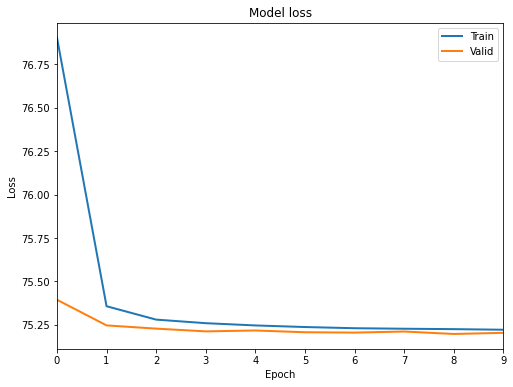

In [17]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
#plt.ylim(2.5,4)
plt.xlim(0,epochs-1)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

why does the loss keep going down? higher training rate? just the nature of loglikelihood?

In [18]:
#lstm_autoencoder = tf.keras.models.load_model(
#    '../models/LSTM_Autoencoder_prob_128', custom_objects=None, compile=True
#)

## Predictions using the Autoencoder
    - test for all faults
    - test for performance on individual faults "only fault n"
    - different cuts for different faults?

Draw n-times for the validation data set

every forward pass draws from the final distribution

this is computationally expensive but we get a posterior distribution to evaluate

in production there would be a smaller window used so computation time is significantly lower

In [19]:
n_vals = 10
yhats = [lstm_autoencoder.predict(X_valid_scaled) for _ in range(n_vals)]

use the predictions like an ensemble

In [20]:
#average over all predictions 
avg = np.squeeze(yhats).mean(axis=0)
std = np.squeeze(yhats).std(axis=0)
print(np.shape(avg))

#calculate some regression metrics
mse = np.mean(np.power(flatten(X_valid_scaled)-avg,2),axis=1)
print(mse)

wmse = np.mean(np.power((flatten(X_valid_scaled)-avg)/std,2),axis=1)
print(wmse)

anomaly = np.mean(np.power((flatten(X_valid_scaled)-avg)*std,2), axis=1)
print(anomaly)

y_valid[y_valid!=0] = 1
error_df = pd.DataFrame({'MSE': mse,
                         'Weighted MSE': wmse,
                         'anomaly' : anomaly,
                         'True_class': y_valid.tolist()})

error_df.to_csv('error_df.csv')

(38400, 53)
[662.20440492   0.92743765  13.54782663 ...   0.72813887  83.32049219
   0.96974841]
[990.56328077   1.13233037  21.98470065 ...   1.26491353 103.93520325
   1.08020783]
[5.59004631e+02 8.96566288e-01 8.45321366e+00 ... 5.14734639e-01
 1.03832080e+02 1.04618096e+00]


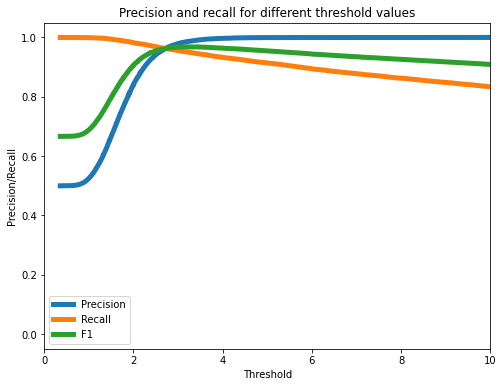

In [21]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['Weighted MSE'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0,10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

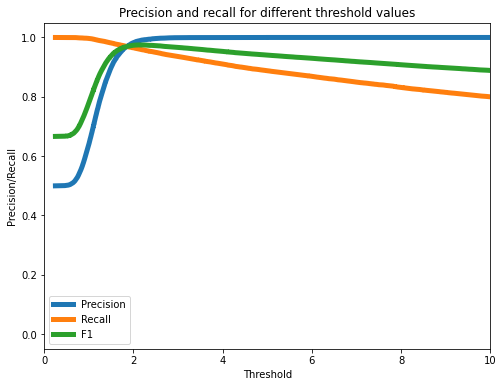

In [22]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['MSE'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0,10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

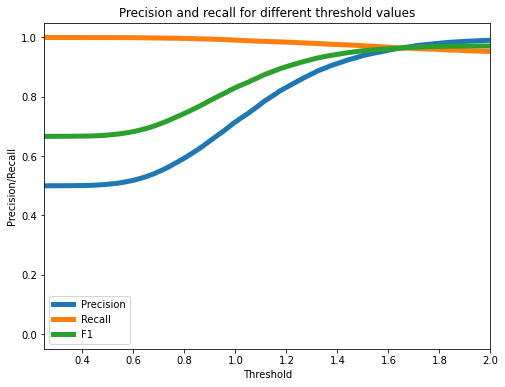

In [23]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['anomaly'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0.25,2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

choose a threshold by eye looking at the scores

In [37]:
threshold_fixed = 1.65
pred_y = [0 if e < threshold_fixed else 1 for e in error_df['anomaly'].values]
acc = metrics.accuracy_score(error_df.True_class, pred_y)
prec = metrics.precision_score(error_df.True_class, pred_y)
print('Accuracy: ', acc)
print('Precision: ', prec)

Accuracy:  0.9647395833333333
Precision:  0.9645648775403857


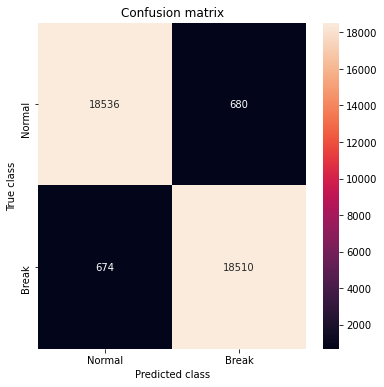

In [25]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

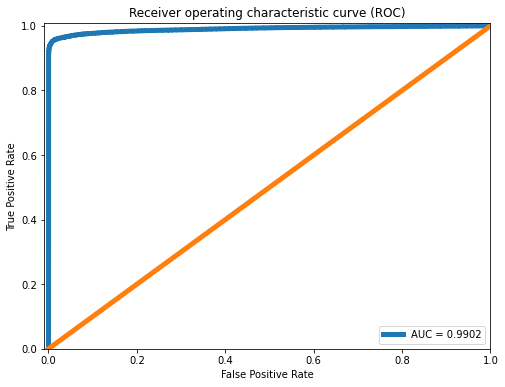

In [38]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df['anomaly'])
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.4f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Do this for all different faults?

Or train another LSTM on top that does the classification